In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler


import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane import AngleEmbedding, AmplitudeEmbedding


In [2]:
# U='U_TTN'
# U_p=2
# U='U_9'
# U_p=2
# U='U_15'
# U_p=4
# U='U_13'
# U_p=6
# U='U_14'
# U_p=6
U='U_SO4'
U_p=6
# U='U_5'
# U_p=10
# U='U_6'
# U_p=10
# U='U_SU4'
# U_p=15

totol_params=2*U_p+2


torch.manual_seed(42)
np.random.seed(42)


os.environ["OMP_NUM_THREADS"] = "1"

step = 0.003               # Learning rate
batch_size = 32              # Number of samples for each training step
num_epochs = 50              # Number of training epochs

gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

train_all_loss=[]
train_all_acc=[]
val_all_loss=[]
val_all_acc=[]
best_accuracy=0

device = torch.device("cpu")

temp = 5
alpha = 0.5

In [3]:
train_f=[[37, 63, 869, 872, 984, 997, 1076, 1128, 1179, 1701, 2058, 2084, 2435, 2526, 2914, 2944, 2996, 3337, 3429, 3943, 3953, 4994, 5468, 5583, 5627, 5711, 5886, 6245, 6292, 6316, 6367, 6591, 6648, 7135, 7203, 7338, 7882, 8019, 8247, 8349, 8369, 8449, 8531, 8896, 9195, 9287, 9329, 9869, 9890, 9914, 10010, 10242, 10564, 10732, 10974, 11071, 11231, 11791, 11887, 11974, 12351, 12897, 13335, 13609, 13738, 13777, 13911, 14102, 14137, 14329, 14613, 14629, 14712, 14919, 15130, 15142, 15156, 15288, 15520, 15567, 15663, 15711, 16122, 16485, 16868, 17327, 17379, 18222, 18301, 18878, 19179, 19376, 19399, 19492, 19856, 20463, 20478, 20510, 20551, 21353, 21735, 21898, 22245, 22265, 22364, 22429, 22430, 22445, 22640, 22752, 23088, 23464, 23521, 23842, 24072, 24105, 24148, 24399, 24640, 24676, 24755, 25039, 25085, 25092, 25584, 25650, 25690, 26040, 26184, 26438, 26508, 27148, 27257, 27289, 27327, 27446, 27466, 27749, 27820, 28108, 28295, 28323, 28423, 28690, 28821, 28896, 28965, 29235, 29262, 29374, 29468, 29578, 29732, 29750, 30480, 30678, 31194, 31369, 31392, 31497, 31581, 31808, 31877, 32007, 32151, 32708, 32899, 33078, 33330, 34025, 34099, 34283, 34416, 34523, 34538, 34562, 34737, 34839, 34867, 35064, 35067, 35646, 36090, 36116, 36168, 37047, 37092, 37189, 37220, 37921, 37977, 38008, 38042, 38055, 38157, 38231, 38559, 39656, 39715, 39874, 39898, 40115, 40313, 40335, 40457, 40611, 40649, 40732, 40760, 40813, 41158, 41288, 41368, 41412, 42224, 42262, 42324, 42389, 43059, 43265, 43443, 43960, 44199, 44363, 45058, 45061, 45128, 45503, 45504, 45695, 46235, 46273, 46443, 46582, 46628, 47000, 47073, 47371, 47482, 47714, 47812, 48200, 48529, 48612, 48929, 49013, 49374, 49429, 49974, 50026, 50257, 50424, 50684, 51299, 51314, 51327, 51789, 52036, 52154, 52161, 53077, 53085, 53354, 53401, 53469, 53533, 53573, 54600, 54690, 55105, 55275, 55408, 55457, 55588, 55721, 56397, 56429, 56509, 56674, 56835, 56868, 56908, 57067, 57120, 57601, 58116, 58275, 58350, 58376, 58560, 58617, 58645, 58647, 58649, 58665, 58765, 59372, 59420, 59605, 59840], [70, 134, 309, 398, 535, 609, 1597, 2202, 2225, 2552, 2645, 2853, 3926, 3966, 4137, 4319, 4731, 4810, 4821, 4900, 4944, 4993, 5850, 5966, 6052, 6183, 6458, 6617, 6654, 6702, 6851, 7075, 7175, 7317, 7324, 7536, 7572, 7622, 7747, 8162, 8194, 8319, 8332, 8530, 8836, 8934, 8970, 9011, 9130, 9815, 9842, 9902, 9907, 10048, 10268, 10301, 10519, 10803, 10971, 11272, 11395, 11440, 11637, 12158, 12241, 12318, 12971, 13372, 13398, 13474, 13542, 13711, 13992, 14079, 14682, 14758, 14767, 15959, 15974, 16021, 16107, 16278, 17030, 17367, 17394, 17402, 17425, 17488, 17759, 17846, 17854, 17872, 17965, 18256, 18314, 18372, 19096, 19150, 19339, 19552, 19555, 19674, 19735, 19804, 20047, 20064, 20177, 20195, 20746, 20749, 20870, 20875, 21002, 21281, 21568, 21575, 21908, 21979, 22462, 22700, 22859, 23097, 23295, 23303, 23353, 23382, 24339, 24405, 24634, 24678, 24879, 25302, 25354, 25364, 25414, 25421, 25734, 25934, 26279, 26514, 26581, 26757, 26827, 26887, 27969, 28069, 28334, 28387, 28405, 28484, 28793, 29214, 29239, 29480, 29575, 29628, 29840, 30270, 30441, 30894, 31093, 31198, 31265, 31420, 31663, 31685, 31963, 32439, 32535, 32632, 32823, 32986, 33005, 33048, 33295, 33398, 33417, 33458, 33556, 33567, 33725, 33943, 34080, 34269, 34291, 34493, 35000, 35094, 35197, 35212, 35299, 35386, 35719, 35777, 36045, 36626, 36892, 37012, 37650, 38163, 38522, 38558, 38585, 38677, 38713, 38845, 39095, 39102, 39159, 39265, 39270, 39437, 39550, 39805, 40276, 40377, 40525, 40635, 40770, 40973, 41104, 41193, 41237, 41269, 41591, 41809, 42132, 42406, 42440, 42463, 42731, 42834, 42852, 42888, 43128, 43813, 43844, 43989, 44093, 44422, 44482, 44994, 45006, 45372, 45373, 45677, 45768, 45858, 47551, 47576, 47721, 47734, 47904, 48177, 48860, 48943, 49198, 49512, 49592, 49731, 51051, 51083, 51197, 51249, 51397, 51566, 51739, 51949, 52392, 52552, 52887, 52965, 53351, 53604, 53761, 54143, 54165, 54752, 54775, 55080, 55671, 55686, 55855, 56226, 56326, 56955, 56965, 57250, 57287, 57473, 57785, 57888, 57961, 58051, 58181, 58451, 58591, 59694, 59882, 59902], [444, 650, 893, 1264, 1330, 1334, 1563, 1595, 1660, 1998, 2270, 2377, 2389, 2518, 2565, 2585, 2641, 2847, 2887, 3244, 4080, 4096, 4185, 4518, 4610, 4716, 4722, 4777, 4819, 4938, 5013, 5151, 5638, 5647, 5677, 6080, 6105, 6161, 6307, 6841, 6933, 7196, 7554, 8201, 8211, 8334, 8473, 8565, 8591, 8611, 8810, 8834, 8960, 8966, 8977, 9186, 9218, 9449, 9546, 10300, 10354, 10570, 10824, 10941, 11106, 11384, 11865, 12234, 12243, 12608, 12950, 13039, 13059, 13299, 13370, 13374, 13857, 13930, 14273, 15067, 15270, 15295, 15403, 15748, 15902, 16046, 16104, 16123, 16772, 16858, 17046, 17080, 17123, 17241, 17836, 18017, 18036, 18210, 18231, 18841, 18930, 19154, 19423, 19466, 19468, 19737, 19999, 20224, 20240, 20284, 20382, 20411, 20454, 20581, 20595, 20786, 21194, 21507, 21528, 21557, 21615, 21845, 22491, 22594, 22635, 22701, 22852, 22958, 23177, 23718, 23764, 23794, 23942, 24732, 25332, 25442, 25617, 25807, 26461, 26509, 26522, 26613, 26779, 27010, 27108, 27131, 27503, 27752, 27880, 28210, 28285, 28560, 28630, 28844, 29624, 30064, 30078, 30094, 30477, 30522, 30561, 30570, 30669, 30690, 30762, 32010, 32024, 32405, 32606, 32678, 32751, 32934, 32989, 33027, 33068, 33210, 33233, 33469, 33547, 33727, 34308, 34559, 34627, 35240, 35340, 35456, 35770, 35927, 36120, 36600, 37234, 37258, 37486, 37570, 37631, 37671, 37863, 37918, 37969, 38635, 39283, 39343, 39476, 39682, 39688, 40589, 40747, 41082, 41207, 41398, 41702, 41900, 41937, 42319, 42373, 42413, 42443, 42535, 43241, 43479, 43486, 43576, 43630, 43854, 44362, 44424, 44653, 45501, 45972, 46082, 46214, 46259, 46414, 46556, 46863, 47230, 47249, 47743, 47782, 48158, 49034, 49776, 49782, 50167, 50218, 50700, 50705, 50897, 50933, 51119, 51151, 51212, 51241, 51418, 51541, 51575, 51870, 52011, 52410, 52456, 52684, 52841, 52851, 52898, 52987, 53017, 53029, 53266, 53522, 53639, 53656, 53884, 54075, 54527, 54714, 54754, 55319, 55326, 55540, 56394, 56498, 56579, 56682, 57151, 57284, 57363, 57439, 57478, 57619, 57936, 57939, 58137, 58670, 58962, 59076, 59188, 59365, 59476, 59721, 59816], [198, 291, 327, 767, 1055, 1108, 1150, 1351, 1588, 1971, 2241, 3108, 3400, 3576, 3591, 3656, 3803, 4136, 4461, 4628, 5434, 5753, 5852, 5970, 6089, 6297, 6592, 6920, 7584, 7626, 8094, 8254, 8551, 8709, 8710, 8818, 8821, 8888, 8958, 9146, 9553, 9670, 9868, 9959, 9974, 10011, 10210, 10606, 10677, 10872, 11513, 11693, 11714, 11719, 11752, 11863, 11958, 12592, 12698, 12836, 13124, 13208, 13516, 13543, 13713, 14577, 14736, 14856, 14878, 15031, 15246, 15336, 15793, 15869, 15872, 16569, 16708, 16748, 16774, 16867, 17280, 17333, 17352, 17496, 17646, 17929, 18227, 18503, 18742, 19215, 19326, 19333, 19348, 19495, 19615, 19655, 19675, 19878, 20985, 21018, 21182, 21359, 21505, 21512, 21559, 21625, 21974, 22946, 23144, 23517, 24326, 24333, 24358, 24442, 24597, 24651, 24987, 25032, 25055, 25311, 25409, 25454, 25523, 25641, 25861, 26123, 26306, 26307, 26383, 26463, 26942, 27212, 27847, 28444, 28626, 29061, 29097, 29504, 29636, 29642, 30062, 30090, 30417, 30423, 30461, 30540, 30571, 30960, 30984, 31345, 31409, 31587, 31641, 31745, 31788, 31791, 31925, 32203, 32484, 32685, 32775, 32850, 33239, 33445, 33649, 33694, 33745, 33772, 33966, 34058, 34145, 34268, 34333, 34736, 34898, 35156, 35574, 35643, 35658, 35796, 35870, 36023, 36082, 36154, 36575, 36604, 36855, 36946, 37124, 37205, 37374, 37622, 37627, 37703, 37718, 37786, 37792, 38089, 38241, 38410, 38732, 38735, 39349, 39412, 39445, 39641, 40385, 40532, 40619, 40836, 41015, 41067, 41136, 41299, 41411, 41629, 41740, 41776, 41929, 42120, 42203, 42215, 42398, 42636, 42777, 42841, 43126, 43135, 43428, 43853, 43902, 44546, 44557, 45046, 45135, 45563, 45597, 45642, 45656, 45764, 46523, 46857, 46986, 47140, 47628, 47724, 47725, 47979, 48258, 48722, 49080, 49122, 49789, 49813, 50206, 50262, 50265, 50312, 50374, 50516, 50683, 52111, 52168, 52379, 52394, 52435, 52543, 52692, 52891, 53035, 53225, 53325, 53838, 54199, 54291, 54730, 54735, 54977, 55116, 55249, 55547, 55881, 56006, 56136, 56164, 56305, 56324, 56437, 56561, 56823, 56871, 56921, 57308, 57735, 57833, 58144, 58656, 58760, 59870, 59957], [289, 706, 742, 882, 1050, 1345, 1630, 1633, 1865, 1911, 1928, 1932, 1967, 2277, 2449, 2801, 3183, 3240, 3388, 3838, 4297, 4409, 4633, 4919, 5217, 5549, 5623, 5703, 5777, 6323, 6653, 7578, 7722, 7826, 8370, 8737, 8854, 9282, 9337, 9391, 9465, 9761, 10549, 11512, 11567, 11770, 11783, 11953, 11955, 11967, 12485, 12644, 12779, 12972, 13125, 13291, 13441, 13446, 13650, 13864, 14349, 14637, 14774, 14785, 15352, 15359, 15521, 15563, 16856, 17057, 17415, 17498, 17896, 17970, 18054, 18332, 18582, 18941, 19107, 19252, 19697, 20182, 20396, 20620, 20653, 21119, 21223, 21541, 21627, 21988, 22525, 22537, 22553, 22595, 22602, 22660, 22985, 23014, 23083, 23121, 23406, 23565, 24113, 24334, 24365, 24378, 24713, 24894, 25333, 25361, 25616, 25887, 26288, 26480, 26704, 26890, 27055, 27056, 27102, 27371, 27514, 27612, 27765, 27800, 27832, 27901, 28164, 28190, 28487, 28501, 28843, 28938, 29011, 29256, 29372, 29792, 29942, 30016, 30108, 30169, 30613, 30763, 30830, 31484, 31517, 31522, 31541, 31692, 32045, 32178, 32556, 33083, 33922, 34290, 34389, 34464, 34545, 34570, 35136, 35362, 35413, 35418, 35849, 35879, 36017, 36200, 36226, 36400, 36466, 36675, 36676, 36923, 37128, 37171, 37410, 37546, 37603, 38227, 38323, 38498, 38515, 38630, 38821, 39024, 39063, 39590, 39799, 40226, 40238, 40354, 40449, 41093, 41206, 41678, 41886, 41906, 42033, 42128, 42216, 42236, 42484, 43038, 43621, 43781, 43947, 44068, 44379, 44594, 44712, 44877, 45009, 45173, 45391, 45670, 45847, 46022, 46128, 46150, 46305, 46357, 46384, 46976, 47001, 47086, 47566, 47981, 48252, 48310, 48373, 48448, 48581, 48608, 48690, 48957, 49196, 49251, 49379, 50154, 50282, 50388, 50835, 51046, 51049, 51225, 51325, 51657, 51703, 52007, 52708, 52958, 53426, 53452, 53559, 53867, 53965, 53974, 54009, 54041, 54801, 54826, 54903, 55339, 55418, 55427, 55641, 55736, 55812, 55860, 55898, 56331, 56406, 56422, 56596, 56698, 56763, 56827, 57082, 57144, 57184, 57209, 57370, 57422, 57589, 57677, 57724, 58057, 58209, 58212, 58364, 58548, 58744, 58823, 58873, 59126, 59232, 59300, 59432, 59608, 59933, 59951], [437, 879, 924, 1039, 1283, 1490, 1556, 2000, 2037, 2266, 2279, 2933, 2948, 3870, 4558, 4622, 5066, 5303, 5382, 5685, 5752, 5887, 6068, 6096, 6177, 6434, 6664, 7193, 7475, 7535, 7546, 7840, 8056, 8178, 8183, 8252, 8421, 8938, 9228, 9387, 9951, 10173, 10397, 10421, 10492, 10536, 10656, 10665, 10764, 10777, 10943, 11055, 11569, 11707, 12467, 12487, 12978, 13058, 13120, 13237, 13368, 13681, 13783, 13843, 14218, 14370, 14404, 14609, 14639, 14907, 15594, 15720, 15812, 15819, 15834, 16165, 16494, 16513, 16592, 17201, 17453, 17794, 18141, 18189, 18366, 18553, 19081, 19578, 19846, 20091, 20200, 20569, 20586, 20754, 20777, 20914, 21275, 21365, 21416, 21588, 21677, 21779, 21850, 21976, 22211, 22264, 22845, 22907, 22951, 22973, 23006, 23424, 23434, 23640, 24107, 24255, 24579, 24890, 24908, 25192, 25273, 25494, 25623, 25675, 25711, 26037, 26313, 26926, 27002, 27079, 27193, 27259, 27408, 27801, 27845, 28057, 28534, 29037, 29343, 29760, 30864, 30957, 31186, 31473, 31519, 31819, 32074, 32168, 32248, 32323, 32372, 32567, 32737, 32748, 32757, 33033, 33077, 33404, 33448, 33475, 33700, 34270, 34276, 34309, 34478, 35310, 35406, 35515, 35535, 35567, 35727, 35747, 35766, 35977, 36028, 36087, 36453, 36539, 36559, 36729, 36999, 37066, 37114, 37270, 37300, 37438, 37551, 37874, 37929, 38240, 38252, 38739, 38851, 38864, 38896, 39722, 39803, 39903, 39972, 40021, 40154, 40731, 41032, 41147, 41314, 41370, 41582, 41938, 42232, 42428, 42447, 42889, 43066, 43221, 43412, 43803, 44665, 44752, 44910, 44916, 45111, 45452, 45711, 45947, 46102, 46307, 46996, 47021, 47081, 47250, 47256, 47284, 47301, 47873, 48161, 48249, 48564, 48971, 49023, 49079, 49455, 49658, 49783, 50155, 50223, 50322, 50406, 50690, 50768, 51177, 51366, 51494, 51718, 51795, 51852, 52665, 53053, 53120, 53292, 53316, 53617, 53690, 53718, 53797, 54051, 54091, 54092, 54429, 54604, 54839, 54880, 54970, 55076, 55229, 55591, 55712, 55795, 56002, 56246, 56898, 57028, 57234, 57248, 57824, 58119, 58175, 58403, 58688, 58894, 58957, 59305, 59459, 59546, 59609, 59662, 59669, 59810, 59823, 59947, 59968], [286, 759, 1020, 1303, 1358, 1466, 1503, 1686, 1750, 1781, 1802, 1957, 2178, 2196, 2214, 2293, 2397, 2486, 3221, 3330, 3421, 3445, 3772, 3820, 4087, 4463, 4477, 5070, 5126, 5554, 5556, 5566, 5686, 5780, 5810, 5832, 5877, 6313, 6572, 6602, 6692, 7109, 7195, 7717, 7957, 8004, 8398, 8862, 9254, 9338, 9723, 10037, 10731, 11038, 11158, 11253, 11307, 11684, 11941, 11985, 12170, 12220, 12448, 12469, 12541, 13010, 13207, 13709, 14101, 14159, 14167, 14421, 14453, 15314, 15450, 15565, 15957, 16064, 16648, 16653, 16726, 16936, 17176, 17589, 17623, 17652, 18140, 18520, 18593, 18771, 18971, 19062, 19309, 19451, 19647, 19661, 19745, 19946, 19984, 20005, 20154, 20233, 20555, 20663, 20984, 21113, 21316, 21373, 21419, 21772, 21862, 21955, 22221, 22257, 22258, 22383, 22385, 22559, 22633, 22814, 22851, 23195, 23236, 23465, 23476, 24380, 24423, 24802, 24827, 25047, 25559, 25992, 26124, 26168, 26452, 26498, 26657, 26670, 26677, 26777, 27149, 27156, 27350, 27653, 27750, 28083, 28287, 28377, 28497, 28680, 28708, 28870, 29537, 29872, 29966, 30350, 30392, 30822, 31071, 31118, 31303, 31646, 31686, 31955, 32050, 32219, 32222, 33035, 33401, 33513, 33550, 33595, 33689, 33704, 33812, 33886, 33916, 34342, 34374, 34413, 34658, 34748, 35154, 35241, 36002, 36067, 36129, 36425, 36616, 36905, 37310, 37535, 38156, 38347, 38390, 38578, 38694, 38796, 38958, 39205, 39336, 39353, 39601, 39665, 39777, 39870, 40828, 40862, 40894, 41089, 41142, 41316, 41410, 41439, 41849, 41995, 42075, 42350, 42847, 42869, 42937, 42972, 43095, 44073, 44102, 44843, 45023, 45138, 45241, 45262, 45581, 45593, 46101, 46186, 46420, 46626, 46994, 47084, 47220, 47239, 47376, 47450, 47699, 48188, 48219, 48605, 49293, 49403, 49505, 49699, 49910, 50506, 50556, 50623, 50666, 50938, 51115, 51690, 52263, 52273, 52542, 52688, 53005, 53111, 53398, 53555, 53557, 53991, 54124, 54150, 54206, 54360, 54403, 54583, 55143, 55307, 55456, 55670, 55703, 55754, 56211, 56520, 56629, 56790, 56863, 56904, 56963, 58281, 58304, 58345, 58534, 58554, 58592, 58598, 58623, 58755, 59292, 59632, 59877, 59895], [387, 853, 981, 1166, 1300, 1322, 1376, 1919, 2102, 2187, 2512, 2522, 2618, 2676, 2701, 2848, 2852, 3633, 3640, 3750, 3992, 4217, 4227, 4394, 4499, 4618, 4888, 5014, 5068, 5089, 5182, 5441, 5626, 5851, 6339, 6455, 6623, 6862, 6881, 7113, 7301, 7781, 8123, 8502, 9097, 9327, 9373, 9432, 9551, 9588, 9681, 9882, 9954, 10077, 10086, 10263, 11054, 11168, 11235, 11616, 11703, 12278, 12287, 12304, 12413, 12558, 12597, 12676, 12865, 13091, 13136, 13187, 13188, 13337, 13380, 13410, 13776, 13815, 14145, 14387, 14727, 14741, 15086, 15098, 15168, 15209, 15490, 15499, 15635, 16478, 16496, 16630, 16672, 16710, 16711, 16809, 16970, 17228, 17420, 17443, 17719, 17724, 18020, 18429, 18472, 18479, 18671, 18729, 18736, 18843, 18844, 19525, 19800, 19869, 20158, 20189, 20227, 20260, 20312, 20404, 20579, 20765, 21243, 21824, 22022, 22348, 22399, 22528, 22817, 22911, 23798, 24131, 24155, 24200, 25130, 25816, 25833, 25841, 25982, 25985, 26049, 26088, 26162, 26304, 26322, 26591, 27468, 27516, 27717, 28053, 28071, 28180, 28211, 28575, 28897, 29032, 29298, 29607, 29625, 29762, 30109, 30154, 30558, 30767, 30913, 31319, 32844, 33287, 33809, 33830, 34501, 34599, 34916, 35121, 35203, 35372, 35544, 35837, 35863, 36284, 36498, 36762, 36902, 36916, 37034, 37494, 37818, 37947, 38015, 38075, 38639, 38650, 39010, 39150, 39244, 39246, 39477, 39687, 39760, 40118, 40186, 40222, 40243, 40476, 40679, 41779, 41928, 41998, 42282, 42378, 42403, 42466, 42725, 42824, 43340, 43384, 44015, 44141, 44353, 44570, 44669, 44807, 44911, 44975, 46190, 46515, 46607, 46737, 46851, 46874, 46906, 47203, 47604, 47893, 48035, 48298, 48343, 48874, 49069, 49240, 49320, 49372, 49551, 49866, 50046, 50066, 50129, 50234, 50464, 51074, 51080, 51113, 51282, 51344, 51829, 52010, 52013, 52162, 52436, 52579, 52998, 53003, 53183, 53242, 53523, 53763, 53770, 53855, 54167, 54385, 54396, 54957, 55346, 55448, 55659, 55744, 55759, 55842, 56086, 56209, 56287, 56518, 56722, 56769, 56816, 57078, 57540, 57921, 58090, 58299, 58520, 58524, 58606, 58975, 59048, 59646, 59724, 59745, 59908, 59925], [734, 740, 831, 1013, 1319, 1788, 1943, 3144, 3432, 3891, 3931, 3959, 3968, 3976, 4100, 4103, 4324, 4383, 4481, 4521, 4609, 4705, 4909, 4927, 5119, 5435, 5534, 5827, 6620, 6677, 6728, 6905, 6957, 6962, 7142, 7182, 7308, 7768, 7844, 8496, 8928, 9152, 9178, 9220, 9241, 9285, 9358, 9564, 9686, 9726, 9782, 9852, 10222, 10490, 10499, 10753, 10936, 11239, 11613, 11796, 11872, 11923, 12609, 12633, 12710, 13186, 13407, 13422, 13554, 13954, 13990, 14993, 15056, 15096, 15366, 15595, 15766, 15820, 16246, 16252, 16274, 16500, 16752, 16826, 17112, 17270, 17290, 17499, 17765, 19079, 19557, 19603, 19665, 19988, 20102, 20261, 20387, 20905, 21125, 21146, 21188, 21280, 21399, 21486, 22808, 23052, 23071, 23316, 23383, 23414, 23426, 23674, 23729, 23987, 24123, 24147, 24190, 24479, 24598, 24686, 24826, 24909, 25256, 25556, 25568, 25582, 25975, 25976, 26023, 26443, 26580, 27024, 27121, 27126, 27312, 27358, 28093, 28198, 28581, 28887, 28959, 29183, 29335, 29745, 30185, 30236, 30478, 30937, 31023, 31414, 31474, 31611, 31851, 32078, 32270, 32473, 32502, 32995, 33072, 33089, 33097, 33273, 33755, 33883, 33997, 34212, 34422, 34663, 34738, 34933, 35036, 35042, 35295, 35467, 35541, 35559, 35733, 36114, 36182, 36275, 36445, 36529, 36582, 36652, 36983, 37039, 37219, 37431, 37434, 37768, 37774, 38135, 38249, 38271, 38331, 38544, 39793, 39864, 39872, 40503, 40875, 41046, 41235, 41544, 41621, 41663, 41699, 41901, 42479, 42749, 42941, 43072, 43091, 43201, 43455, 43515, 43749, 43901, 43953, 44427, 44507, 44604, 44719, 45427, 45553, 45647, 45684, 45738, 45877, 45954, 46063, 46730, 47093, 47274, 47304, 47498, 47723, 47851, 47903, 48081, 48206, 48309, 48407, 48560, 48891, 49502, 49634, 49660, 49803, 49901, 49963, 50785, 50883, 50925, 51058, 51143, 51412, 51612, 51769, 51846, 52067, 52171, 52285, 52398, 52465, 52523, 52808, 52860, 53508, 53520, 53756, 54327, 54387, 54488, 54554, 54919, 54990, 55122, 55156, 55182, 55293, 55392, 55581, 55614, 55695, 55880, 56284, 56956, 57042, 57087, 57108, 57355, 58031, 58293, 58595, 58748, 59123, 59277, 59967, 59989], [80, 110, 170, 482, 631, 707, 806, 1161, 1507, 1574, 1620, 1925, 1962, 2141, 2284, 2579, 2821, 2953, 3316, 3389, 3636, 3649, 3662, 3781, 3796, 3913, 3977, 3991, 4025, 4060, 4093, 4122, 4124, 4313, 4973, 5093, 5411, 5492, 5658, 5727, 5794, 5803, 5836, 6036, 6334, 6734, 6769, 6820, 7023, 7071, 7274, 7545, 7714, 7757, 7922, 8356, 8620, 8750, 8837, 8953, 8971, 9176, 9481, 9532, 10143, 10387, 10857, 11208, 11415, 11688, 11820, 11825, 11884, 12050, 12175, 12237, 12529, 12721, 12999, 13063, 13116, 13130, 13304, 13359, 13429, 13435, 13461, 13462, 13739, 13949, 15089, 15151, 15670, 15858, 16039, 16137, 16253, 16330, 16341, 16444, 16522, 16801, 16953, 17166, 17186, 17297, 17475, 17671, 18146, 18166, 18350, 18558, 18598, 19537, 19539, 19596, 19992, 20505, 20767, 20826, 20830, 21040, 21162, 21551, 21571, 21842, 22514, 22540, 22854, 22948, 23275, 23502, 23548, 23732, 23976, 23989, 24230, 24593, 24759, 24825, 25063, 25404, 25821, 25837, 25852, 26025, 26259, 26349, 26527, 26764, 27087, 27237, 27344, 27368, 27383, 27430, 27679, 28183, 28329, 28446, 28984, 29001, 29036, 29108, 29124, 29346, 29390, 29406, 29710, 29980, 30204, 30394, 30758, 30808, 31072, 31094, 31244, 31337, 31353, 31675, 31803, 31888, 31939, 32021, 32249, 32759, 33544, 33597, 33907, 34195, 34301, 34592, 34603, 34616, 34824, 35191, 35475, 36013, 36104, 36196, 36319, 36587, 36832, 37123, 37466, 38064, 38182, 38292, 38809, 39016, 39148, 39172, 39192, 39538, 39733, 39924, 39993, 40174, 40522, 40585, 41033, 41349, 41403, 41422, 41583, 41833, 41875, 41903, 42298, 42400, 42597, 42860, 43028, 43324, 43385, 43611, 43888, 44043, 44228, 44592, 44670, 45323, 45337, 45688, 46032, 46373, 46497, 46655, 46706, 46987, 47017, 47878, 48388, 48477, 48927, 49010, 49128, 49383, 50239, 50329, 50467, 50557, 50859, 51036, 51123, 51253, 52138, 53166, 53190, 53386, 53393, 53396, 53397, 53505, 54021, 54508, 54793, 55009, 55064, 55092, 55347, 55569, 56092, 56408, 56425, 57079, 57239, 57267, 57281, 57545, 58059, 58069, 58264, 58918, 59024, 59084, 59214, 59514, 59650, 59939]]
valid_f=[[303, 633, 667, 712, 2597, 4749, 5096, 6422, 7129, 7305, 8533, 8653, 8855, 8877, 9209, 10240, 11712, 12134, 12741, 13582, 13583, 13962, 14158, 14161, 14717, 15581, 15926, 17462, 17466, 17693, 19419, 19902, 19985, 20123, 20334, 20911, 20958, 21242, 22378, 23741, 25167, 25836, 26338, 26371, 27484, 28540, 29187, 29205, 31288, 32313, 33023, 33292, 33345, 33534, 34016, 34238, 36621, 37467, 37980, 39263, 39446, 39606, 39935, 39975, 40237, 40630, 40633, 40833, 40915, 41117, 41286, 41570, 41634, 41743, 42038, 42045, 42081, 42664, 42896, 43045, 43554, 44411, 44513, 46479, 46604, 47736, 48790, 49306, 50629, 52204, 52470, 52613, 54263, 54804, 55622, 57408, 57543, 58768, 59143, 59241], [128, 638, 2047, 2123, 2197, 2767, 2807, 2918, 3111, 5963, 6718, 6900, 8166, 8550, 10318, 11735, 13273, 13315, 13574, 14466, 14858, 14870, 15175, 15684, 16735, 17012, 17125, 18207, 19482, 19622, 19652, 20302, 20438, 20443, 21202, 21921, 23012, 23841, 25244, 25310, 25774, 25885, 26388, 26421, 26610, 27895, 28223, 29567, 29615, 30606, 32034, 34017, 35357, 35487, 35819, 36071, 36801, 37513, 37911, 38039, 38779, 39830, 40190, 40664, 40790, 41559, 41637, 41805, 42268, 42673, 43246, 43336, 44324, 45433, 45556, 45861, 45962, 47022, 47272, 47279, 48361, 48679, 49002, 49260, 49641, 49927, 50951, 51015, 51129, 52046, 52088, 52619, 53405, 54059, 56192, 57109, 57505, 59071, 59247, 59954], [555, 1558, 1679, 2508, 4269, 5843, 5885, 6039, 7266, 7394, 7772, 8277, 9509, 9542, 10073, 10228, 11286, 11856, 12156, 12474, 12911, 13139, 13627, 13919, 15187, 16289, 16895, 17805, 18526, 18643, 19248, 19519, 19721, 20065, 20742, 20847, 21382, 21511, 22027, 22076, 22558, 22778, 23460, 23683, 24623, 25289, 27162, 27444, 27537, 28998, 29784, 30120, 30826, 31638, 32508, 33197, 34371, 34907, 35373, 35453, 35670, 36039, 36147, 36853, 37440, 37526, 37638, 37763, 37904, 38024, 38733, 39146, 40425, 42950, 43871, 44784, 45268, 45283, 45852, 46277, 46841, 47024, 47460, 48191, 49582, 50478, 51419, 51751, 52370, 53837, 53963, 54262, 55862, 56120, 56590, 57416, 57871, 58030, 58896, 59991], [12, 433, 1244, 1981, 2468, 3258, 5160, 5770, 6269, 6545, 7966, 9355, 9411, 9639, 10042, 10865, 11037, 11837, 13099, 13601, 13750, 14002, 14636, 15453, 15534, 15544, 16764, 17227, 17832, 18061, 18528, 19601, 20842, 21116, 21458, 21637, 22460, 22733, 23731, 25689, 25941, 25955, 26534, 27917, 28256, 28757, 29294, 29972, 30193, 30692, 31451, 32960, 33099, 33169, 35407, 35568, 36248, 36338, 37454, 38129, 39327, 39704, 39721, 41165, 43192, 44779, 45088, 45327, 45781, 45783, 45836, 45995, 46548, 46821, 46923, 47225, 48311, 48978, 48981, 49137, 50201, 50317, 50529, 51092, 51321, 51890, 53223, 53527, 53595, 54304, 54534, 55893, 55998, 56321, 56420, 58065, 58602, 58966, 58983, 59921], [92, 372, 2157, 3459, 3701, 4055, 4292, 4513, 5032, 6009, 7573, 9029, 9189, 9993, 10159, 10396, 10850, 10918, 11627, 11886, 12538, 13223, 14066, 14537, 15429, 15568, 16048, 17552, 19044, 19294, 19375, 20429, 20650, 20924, 20972, 22997, 23276, 23956, 25184, 25498, 25938, 26235, 26567, 26618, 26767, 28159, 28509, 29207, 29574, 29593, 30215, 30908, 31543, 31668, 31994, 32851, 33248, 33747, 34742, 34780, 35186, 35324, 36092, 37616, 38671, 39245, 39365, 39511, 41499, 42198, 43041, 43157, 43530, 43600, 43934, 44037, 45121, 45231, 45280, 45773, 46498, 46561, 46691, 48286, 48660, 48669, 48835, 50937, 54279, 54324, 54710, 54852, 54911, 55793, 55990, 56320, 56802, 58164, 58555, 59722], [396, 504, 679, 845, 1111, 1328, 2343, 3419, 4167, 5109, 6359, 6389, 7144, 7260, 7591, 7659, 9009, 9344, 9397, 9738, 9770, 10008, 11935, 13092, 13663, 14143, 14839, 14862, 16682, 17387, 19318, 20199, 21550, 22599, 22983, 23870, 24043, 25738, 26198, 26876, 27742, 28477, 28606, 28770, 29890, 30061, 31053, 31151, 31190, 32040, 32132, 33690, 33811, 34602, 34821, 34882, 35029, 35041, 35388, 35495, 36987, 37148, 38134, 40014, 41091, 41731, 42221, 42414, 43245, 44781, 45624, 46878, 47107, 47115, 47319, 47433, 47526, 47845, 48606, 48705, 49032, 49062, 49241, 49316, 50173, 50383, 50601, 51405, 51492, 51646, 51736, 51855, 51955, 52122, 55506, 55953, 56262, 56314, 59278, 59822], [62, 2837, 2849, 2884, 3089, 4018, 4430, 5334, 5910, 7759, 8826, 10036, 10270, 10540, 10671, 11277, 11390, 11635, 12411, 13101, 13696, 14377, 14604, 14610, 14661, 14783, 14804, 15978, 18267, 19356, 19384, 20733, 21348, 21901, 23394, 23654, 23694, 23785, 25219, 26071, 26301, 26766, 27483, 27556, 27890, 28400, 28554, 28702, 28966, 29331, 29725, 29795, 29843, 32320, 32522, 34765, 34783, 35238, 35411, 35726, 35791, 38084, 38101, 38176, 38259, 38479, 38514, 39188, 40560, 41800, 42162, 42667, 42788, 43457, 44287, 44483, 47562, 48636, 48778, 49296, 49418, 49550, 49613, 50108, 51021, 52000, 53422, 54420, 54591, 55135, 55913, 56115, 56937, 57010, 57409, 57554, 57756, 58536, 58578, 59801], [1153, 2995, 4548, 5223, 6130, 6287, 7608, 7852, 8559, 9200, 9657, 10096, 10841, 11838, 13199, 13883, 14307, 14969, 15087, 15202, 15452, 16189, 17513, 18315, 19260, 19844, 20039, 21169, 21400, 21572, 23388, 23941, 24141, 24443, 26021, 26274, 26699, 26721, 27714, 27986, 29709, 29900, 30465, 30936, 31101, 31330, 31542, 31912, 32048, 32150, 32195, 32651, 32716, 34353, 34564, 36003, 37423, 37471, 37960, 38088, 39917, 41232, 41630, 43024, 43408, 43886, 43919, 44572, 44943, 45143, 45180, 45489, 45807, 46274, 49330, 49829, 50984, 51193, 52149, 52825, 53962, 54365, 54378, 54558, 54678, 55084, 55090, 55117, 56076, 56160, 56218, 56701, 57445, 57653, 58095, 58912, 58932, 59031, 59379, 59661], [295, 368, 517, 923, 1193, 1294, 1914, 2349, 3254, 3501, 3979, 4419, 4692, 6214, 7979, 9764, 9799, 9861, 10061, 10197, 10655, 11070, 11741, 12084, 12534, 12658, 13017, 14062, 14305, 14873, 15664, 15749, 15941, 16141, 17145, 17924, 20648, 20876, 20919, 21965, 22810, 23300, 24954, 25486, 26523, 26786, 28341, 28432, 28710, 28726, 30568, 32622, 32639, 33424, 33780, 34312, 34524, 34870, 36745, 36891, 37459, 37979, 38870, 39559, 39599, 40149, 40665, 41363, 42408, 43121, 43145, 43290, 43522, 43579, 43754, 43986, 44172, 45098, 47438, 48475, 49052, 49064, 49579, 49618, 49830, 50410, 50886, 51104, 51645, 52401, 53681, 54471, 54757, 55153, 55807, 55811, 56296, 56357, 56613, 56751], [704, 1733, 2696, 4399, 6790, 6918, 7198, 7264, 7447, 8329, 9614, 9933, 10186, 10232, 10249, 10524, 10794, 11593, 11909, 11924, 12051, 12708, 12965, 13096, 14497, 14974, 16881, 17283, 17689, 19885, 20073, 20130, 20735, 22174, 23539, 23744, 24454, 24497, 24936, 25933, 26215, 26682, 28383, 29305, 29663, 30069, 31854, 33300, 33948, 34072, 34211, 34876, 35160, 35355, 35444, 36062, 36211, 36720, 36863, 37879, 38344, 39000, 39571, 39642, 39953, 40113, 40328, 40786, 41503, 42482, 42826, 43034, 43543, 44026, 44230, 44236, 44429, 45232, 47105, 47853, 48384, 48577, 48987, 49096, 49945, 49988, 50414, 50746, 51708, 52506, 53267, 53882, 55295, 55296, 55850, 56597, 57175, 58407, 59027, 59695]]
test_f=[[13, 101, 794, 804, 854, 932, 1191, 1379, 1487, 1535, 1623, 1713, 1775, 2081, 2385, 2403, 2461, 2492, 2763, 2937, 2944, 2988, 3020, 3243, 3317, 3325, 3368, 3417, 3540, 3680, 3804, 3903, 3989, 4048, 4091, 4186, 4188, 4281, 4353, 4365, 4370, 4447, 4457, 4495, 4515, 4628, 4887, 4891, 5031, 5244, 5251, 5305, 5603, 5659, 5929, 6097, 6117, 6140, 6280, 6319, 6444, 6580, 6672, 6711, 6752, 6753, 6779, 6795, 6833, 6894, 7072, 7162, 7368, 7655, 7693, 7699, 7727, 7835, 7873, 7882, 7887, 7943, 7967, 8195, 8221, 8260, 8548, 8619, 8634, 8763, 8849, 8951, 9016, 9038, 9134, 9220, 9325, 9542, 9666, 9801], [29, 39, 107, 203, 378, 615, 809, 824, 840, 1236, 1240, 1528, 1707, 1785, 1829, 1867, 1939, 2235, 2239, 2357, 2504, 2674, 2789, 2943, 3099, 3227, 3276, 3380, 3420, 3430, 3651, 3652, 3765, 3866, 3919, 3974, 3983, 4010, 4050, 4074, 4085, 4232, 4249, 4303, 4318, 4507, 4564, 4602, 4643, 4655, 4676, 4754, 4932, 4951, 5361, 5370, 5399, 5431, 5520, 5839, 5873, 5902, 5998, 6192, 6419, 6438, 6482, 6678, 6729, 6751, 6799, 6961, 7171, 7270, 7319, 7323, 7325, 7447, 7783, 7944, 8048, 8078, 8100, 8118, 8219, 8439, 8449, 8491, 8708, 8745, 8873, 9222, 9241, 9324, 9345, 9438, 9540, 9612, 9774, 9898], [119, 285, 291, 326, 362, 456, 513, 536, 539, 731, 891, 1050, 1210, 1237, 1352, 1374, 1432, 1462, 1604, 1711, 1965, 2055, 2133, 2157, 2260, 2439, 2787, 2802, 3004, 3048, 3089, 3134, 3212, 3474, 3508, 3681, 3731, 3775, 3862, 3945, 3946, 4135, 4167, 4205, 4248, 4279, 4326, 4456, 4476, 4506, 4713, 4801, 4950, 5037, 5119, 5292, 5308, 5629, 5667, 5723, 5829, 5907, 6118, 6203, 6246, 6266, 6340, 6412, 6754, 6831, 6949, 7205, 7327, 7345, 7349, 7359, 7386, 7406, 7420, 7762, 7781, 7794, 7857, 7909, 7994, 8031, 8059, 8079, 8119, 8208, 8318, 8460, 8612, 8615, 8969, 9318, 9470, 9603, 9847, 9954], [18, 51, 216, 437, 526, 699, 734, 753, 811, 1098, 1315, 1317, 1495, 1605, 1683, 1789, 1798, 1803, 1832, 1840, 1983, 2011, 2533, 2566, 2594, 2618, 2623, 2639, 2767, 2840, 2992, 3010, 3078, 3131, 3150, 3300, 3381, 3409, 3432, 3443, 3484, 3795, 3824, 3947, 4087, 4097, 4128, 4242, 4581, 4688, 4894, 5078, 5224, 5454, 5555, 5724, 5796, 5815, 6009, 6103, 6174, 6177, 6255, 6272, 6371, 6664, 6676, 6882, 6930, 6957, 7140, 7214, 7252, 7292, 7396, 7436, 7568, 7590, 7644, 7771, 7968, 8026, 8080, 8087, 8296, 8411, 8581, 8706, 8777, 8811, 8972, 9056, 9275, 9283, 9342, 9468, 9511, 9581, 9889, 9942], [24, 65, 117, 166, 238, 295, 555, 610, 660, 668, 784, 881, 910, 931, 1010, 1242, 1300, 1440, 1599, 1665, 1786, 2043, 2145, 2249, 2264, 2457, 2615, 2847, 2872, 3133, 3169, 3232, 3235, 3465, 3541, 3596, 3610, 3676, 3793, 4001, 4172, 4217, 4475, 4768, 5004, 5068, 5082, 5084, 5178, 5256, 5260, 5322, 5440, 5525, 5556, 5597, 5842, 5975, 6102, 6265, 6273, 6284, 6460, 6543, 6585, 6660, 6812, 6924, 6941, 7056, 7206, 7251, 7434, 7550, 7653, 7696, 7759, 7775, 7834, 7879, 7972, 8051, 8054, 8095, 8107, 8363, 8392, 8400, 8500, 8583, 8613, 8797, 8917, 8961, 9033, 9347, 9728, 9813, 9873, 9922], [52, 120, 165, 211, 289, 540, 674, 692, 694, 778, 812, 935, 1003, 1046, 1089, 1340, 1378, 1447, 1637, 1641, 1672, 1737, 1752, 1761, 2064, 2125, 2134, 2159, 2346, 2413, 2460, 2682, 2773, 2987, 3102, 3157, 3171, 3312, 3537, 3569, 3619, 3756, 3763, 3788, 3890, 4261, 4356, 4420, 4520, 4645, 4762, 4810, 4828, 4902, 4933, 5206, 5410, 5432, 5473, 5510, 5742, 5807, 5852, 5972, 6136, 6277, 6324, 6823, 6832, 6860, 6981, 7018, 7108, 7274, 7315, 7388, 7397, 7430, 7451, 7622, 7676, 8034, 8122, 8142, 8160, 8170, 8214, 8453, 8632, 8652, 8656, 9035, 9331, 9428, 9478, 9493, 9883, 9907, 9941, 9982], [201, 463, 623, 937, 942, 1161, 1388, 1593, 1662, 1688, 1733, 1822, 1916, 1943, 1971, 1977, 2047, 2066, 2210, 2360, 2562, 2651, 2672, 2721, 2728, 2801, 2976, 2995, 3182, 3269, 3403, 3671, 3712, 3725, 3748, 3853, 3961, 4132, 4239, 4243, 4346, 4536, 4565, 4686, 4798, 4898, 5088, 5136, 5286, 5378, 5383, 5819, 5834, 5948, 5966, 6113, 6218, 6229, 6294, 6399, 6459, 6509, 6550, 6675, 6685, 6896, 7113, 7122, 7152, 7285, 7540, 7596, 7667, 7843, 7860, 7891, 7970, 8013, 8040, 8103, 8148, 8197, 8240, 8542, 8668, 8677, 8804, 8814, 8901, 9086, 9251, 9343, 9361, 9366, 9426, 9494, 9710, 9730, 9815, 9981], [0, 36, 223, 262, 307, 468, 494, 510, 551, 626, 636, 702, 880, 898, 1096, 1386, 1507, 1595, 1716, 1750, 1770, 2059, 2143, 2325, 2377, 2484, 2665, 2666, 2915, 3059, 3079, 3202, 3213, 3316, 3328, 3378, 3423, 3494, 3637, 3643, 3656, 4175, 4214, 4400, 4460, 4487, 4539, 4697, 4837, 4868, 4900, 5114, 5205, 5310, 5371, 5512, 5663, 5835, 5949, 5988, 6006, 6079, 6149, 6306, 6353, 6599, 6741, 6762, 6853, 6960, 7030, 7079, 7145, 7149, 7189, 7276, 7320, 7701, 7744, 7754, 7796, 7985, 8030, 8421, 8455, 8591, 8631, 8654, 8815, 9087, 9186, 9294, 9327, 9515, 9566, 9618, 9711, 9743, 9852, 9958], [84, 128, 134, 146, 266, 344, 466, 582, 641, 693, 1124, 1287, 1364, 1443, 1583, 1613, 1686, 1759, 2102, 2119, 2208, 2211, 2225, 2389, 2451, 2650, 2667, 2691, 2783, 2849, 2935, 3012, 3023, 3062, 3068, 3186, 3519, 3576, 3704, 3816, 3873, 4075, 4092, 4112, 4137, 4290, 4371, 4419, 4478, 4508, 4608, 4626, 4667, 4737, 5016, 5049, 5065, 5118, 5530, 5589, 5644, 5675, 5855, 5875, 6070, 6209, 6262, 6495, 6595, 6834, 6839, 6850, 7099, 7109, 7126, 7220, 7244, 7383, 7450, 7660, 7663, 7765, 7814, 7999, 8216, 8236, 8297, 8726, 8787, 8934, 9068, 9116, 9187, 9326, 9420, 9452, 9722, 9744, 9827, 9991], [62, 209, 322, 488, 575, 630, 673, 733, 813, 913, 954, 1304, 1343, 1385, 1418, 1545, 1594, 1640, 1825, 2009, 2014, 2089, 2189, 2274, 2323, 2548, 2585, 2589, 2696, 2863, 3369, 3411, 3460, 3504, 3597, 3716, 3791, 3872, 3889, 3926, 3981, 4143, 4245, 4363, 4454, 4584, 4592, 4633, 4799, 4823, 4840, 4975, 5130, 5137, 5491, 5546, 5565, 5800, 5813, 5951, 6039, 6081, 6091, 6166, 6173, 6214, 6401, 6411, 6436, 6451, 6508, 6592, 6642, 6656, 6671, 6888, 6903, 7148, 7682, 7827, 7962, 8028, 8230, 8259, 8371, 8426, 8479, 8751, 8807, 8897, 8935, 9397, 9539, 9638, 9659, 9692, 9723, 9733, 9767, 9825]]

In [4]:
# 载入训练集
train_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
# 生成验证集
val_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)
# 生成测试集
test_dataset = torchvision.datasets.MNIST(
    root='dataset/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)
train_data = train_dataset.data
train_targets = train_dataset.targets
val_data = val_dataset.data
val_targets = val_dataset.targets
test_data = test_dataset.data
test_targets = test_dataset.targets

train_d_c = torch.zeros([3000, 28,28], dtype=torch.uint8)
train_t_c = torch.zeros([3000])
all_1=0

val_d_c = torch.zeros([1000, 28,28], dtype=torch.uint8)
val_t_c = torch.zeros([1000])
all_2=0

for i in range(60000):
    if i in train_f[train_targets[i]]:
        train_t_c[all_1]=train_targets[i]
        train_d_c[all_1]=train_data[i]
        all_1=all_1+1
    if i in valid_f[train_targets[i]]:
        val_t_c[all_2]=train_targets[i]
        val_d_c[all_2]=train_data[i]
        all_2=all_2+1


test_d_c = torch.zeros([1000, 28,28], dtype=torch.uint8)
test_t_c = torch.zeros([1000])
all_3=0

for i in range(10000):
    if i in test_f[test_targets[i]]:
        test_t_c[all_3]=test_targets[i]
        test_d_c[all_3]=test_data[i]
        all_3=all_3+1
        
train_dataset.data = train_d_c
train_dataset.targets = train_t_c
val_dataset.data = val_d_c
val_dataset.targets = val_t_c
test_dataset.data = test_d_c
test_dataset.targets = test_t_c

train_data_size = len(train_dataset)
valid_data_size = len(val_dataset)
test_data_size = len(test_dataset)
print(train_data_size)
print(valid_data_size)
print(test_data_size)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

3000
1000
1000


In [5]:
def U_TTN(params, wires):  # 2 params-------1√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_5(params, wires):  # 10 params-----------7√
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_6(params, wires):  # 10 params---------------8√
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_9(params, wires):  # 2 params-----------2√
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])


def U_13(params, wires):  # 6 params--------------4√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])


def U_14(params, wires):  # 6 params-------------5√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])


def U_15(params, wires):  # 4 params------------3√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_SO4(params, wires):  # 6 params------------6√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])


def U_SU4(params, wires):  # 15 params----------------9√
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])


# Pooling Layer 池化层

def Pooling_ansatz1(params, wires):  # 2 params
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])


def Pooling_ansatz2(wires):  # 0 params
    qml.CRZ(wires=[wires[0], wires[1]])


def Pooling_ansatz3(*params, wires):  # 3 params
    qml.CRot(*params, wires=[wires[0], wires[1]])

In [6]:
# Convolutional layers
def conv_layer1(U, params):
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])
    U(params, wires=[0, 7])

def conv_layer2(U, params):
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])
    U(params, wires=[0, 6])

# Pooling layers
def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])
        
def QCNN_structure(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 2 * U_params + 2]

    conv_layer1(U, param1)
    pooling_layer1(Pooling_ansatz1, param3)
    conv_layer2(U, param2)

In [7]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, params, U, U_params):

    AmplitudeEmbedding(q_input_features, wires=range(8), normalize=True)
        
    if U == 'U_TTN':
        QCNN_structure(U_TTN, params, U_params)
    elif U == 'U_5':
        QCNN_structure(U_5, params, U_params)
    elif U == 'U_6':
        QCNN_structure(U_6, params, U_params)
    elif U == 'U_9':
        QCNN_structure(U_9, params, U_params)
    elif U == 'U_13':
        QCNN_structure(U_13, params, U_params)
    elif U == 'U_14':
        QCNN_structure(U_14, params, U_params)
    elif U == 'U_15':
        QCNN_structure(U_15, params, U_params)
    elif U == 'U_SO4':
        QCNN_structure(U_SO4, params, U_params)
    elif U == 'U_SU4':
        QCNN_structure(U_SU4, params, U_params)   
    
    else:
        print("Invalid Unitary Ansatze")
        return False

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in [0, 2, 4, 6]]
    return exp_vals
    

In [8]:
class DressedQuantumNet_S(nn.Module):
    def __init__(self):
        super().__init__()        
        self.flat_net = nn.Flatten()
        self.pre_net = nn.Linear(784, 256)
        self.q_params = nn.Parameter(q_delta * torch.randn(totol_params))
        self.post_net = nn.Linear(4, 10)  # 10分类

    def forward(self, input_features):
        input_features = self.flat_net(input_features)
        pre_out = self.pre_net(input_features)
        
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        
        q_out = torch.Tensor(0, 4)
        q_out = q_out.to(device)

        for elem in q_in:
            q_out_elem = torch.Tensor(quantum_net(elem, self.q_params, U, U_p)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        q_final = self.post_net(q_out)
        
        return q_final

In [9]:
class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()        
        self.flat_net = nn.Flatten()
        self.pre_net = nn.Linear(512, 256)
        self.q_params = nn.Parameter(q_delta * torch.randn(totol_params))
        self.post_net = nn.Linear(4, 10)  # 10分类

    def forward(self, input_features):
        input_features = self.flat_net(input_features)
        pre_out = self.pre_net(input_features)
        
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        
        q_out = torch.Tensor(0, 4)
        q_out = q_out.to(device)

        for elem in q_in:
            q_out_elem = torch.Tensor(quantum_net(elem, self.q_params, U, U_p)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        q_final = self.post_net(q_out)
        
        return q_final

In [10]:
model= DressedQuantumNet_S()

criterion = nn.CrossEntropyLoss()
soft_loss = nn.KLDivLoss(reduction='batchmean') # 蒸馏损失

optimizer= optim.Adam(model.parameters(), lr=step, weight_decay=0.0001)  # 减少过拟合


In [11]:
model_T = torchvision.models.resnet18(pretrained=True)
for param in model_T.parameters():
    param.requires_grad = False
model_T.fc = DressedQuantumNet()

model_T = torch.load('Result/teacher/TL-HQCCNN_MNIST_5000.pth', map_location=device)
model_T.eval()

D:\Anaconda\envs\learn2023\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\learn2023\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
def train_model(model, criterion, optimizer, num_epochs):

    print("Training started:")

    best_acc = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i,(inputs, labels) in enumerate(train_dataloader):
            
            inputs_T=transforms.Resize((224, 224))(inputs)
            inputs_T = inputs_T.repeat([1,3,1,1])
            inputs_T=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(inputs_T)

            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs_t=inputs_T.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs) # 逻辑层输出

            outputs_T = model_T(inputs_T) # 教师的逻辑输出
            
            loss = criterion(outputs, labels) # 学生自身损失
            distillation_loss = soft_loss(
                F.log_softmax(outputs / temp, dim=1),
                F.softmax(outputs_T / temp, dim=1)
            )   # 蒸馏损失
            
            loss = alpha * loss + (1 - alpha) * distillation_loss # 学生损失+蒸馏损失,alpha是超参数
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            ret_T, predictions_T = torch.max(outputs.data, 1)

            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            y_true=[]
            y_pred=[]
            for j, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)

                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predictions.cpu().numpy().tolist())

        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(model, 'Result/ST-HQCCNN_1_MNIST_5000.pth')


        epoch_end = time.time()

        print(
            "\t Training: Loss: {:.4f}, Accuracy: {:.4f}%, "
            "\n\t Validation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.3f}s".format(
                avg_train_loss, avg_train_acc * 100, avg_valid_loss, avg_valid_acc * 100,
                                epoch_end - epoch_start
            ))
        print("\t Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
        train_all_loss.append(avg_train_loss)
        train_all_acc.append(avg_train_acc)
        val_all_loss.append(avg_valid_loss)
        val_all_acc.append(avg_valid_acc)
        best_accuracy=best_acc

In [13]:
train_model(model, criterion, optimizer, num_epochs)

Training started:
Epoch: 1/50
	 Training: Loss: 1.0290, Accuracy: 46.6667%, 
	 Validation: Loss: 1.5554, Accuracy: 59.5000%, Time: 868.860s
	 Best Accuracy for validation : 0.5950 at epoch 001
Epoch: 2/50
	 Training: Loss: 0.7678, Accuracy: 70.8333%, 
	 Validation: Loss: 1.2341, Accuracy: 78.6000%, Time: 859.114s
	 Best Accuracy for validation : 0.7860 at epoch 002
Epoch: 3/50
	 Training: Loss: 0.6107, Accuracy: 85.6000%, 
	 Validation: Loss: 1.0046, Accuracy: 83.5000%, Time: 867.251s
	 Best Accuracy for validation : 0.8350 at epoch 003
Epoch: 4/50
	 Training: Loss: 0.5062, Accuracy: 88.4333%, 
	 Validation: Loss: 0.8525, Accuracy: 86.9000%, Time: 869.411s
	 Best Accuracy for validation : 0.8690 at epoch 004
Epoch: 5/50
	 Training: Loss: 0.4260, Accuracy: 90.1000%, 
	 Validation: Loss: 0.7399, Accuracy: 87.6000%, Time: 867.570s
	 Best Accuracy for validation : 0.8760 at epoch 005
Epoch: 6/50
	 Training: Loss: 0.3702, Accuracy: 91.3333%, 
	 Validation: Loss: 0.6831, Accuracy: 87.9000%, 

	 Training: Loss: 0.0617, Accuracy: 99.9667%, 
	 Validation: Loss: 0.3333, Accuracy: 92.2000%, Time: 782.384s
	 Best Accuracy for validation : 0.9240 at epoch 029
Epoch: 49/50
	 Training: Loss: 0.0633, Accuracy: 99.8333%, 
	 Validation: Loss: 0.3716, Accuracy: 91.3000%, Time: 782.338s
	 Best Accuracy for validation : 0.9240 at epoch 029
Epoch: 50/50
	 Training: Loss: 0.0640, Accuracy: 99.8000%, 
	 Validation: Loss: 0.3418, Accuracy: 91.8000%, Time: 780.664s
	 Best Accuracy for validation : 0.9240 at epoch 029


In [14]:
print(train_all_loss)
print(train_all_acc)
print(val_all_loss)
print(val_all_acc)

[1.0290078015327453, 0.7678354686101277, 0.6107326358159383, 0.5062345349788666, 0.42601321792602537, 0.3702032324473063, 0.3271579438050588, 0.29283665617307025, 0.2692105689048767, 0.24631555004914601, 0.22463105257352192, 0.2061039628982544, 0.1954013570944468, 0.18220649039745332, 0.16977556411425274, 0.16031674156586329, 0.15414308806260427, 0.14227564561367034, 0.13674947361151377, 0.13078238073984783, 0.12258777741591136, 0.11961694407463073, 0.11399171284834544, 0.10745613547166188, 0.10804766062895457, 0.10482043941815694, 0.10318851804733277, 0.09763760727643966, 0.09156579013665517, 0.08972565873463949, 0.08713252850373586, 0.08211677781740824, 0.08396640234192213, 0.08154786378145218, 0.07963373668988545, 0.08015705627202988, 0.07847266060113907, 0.07202888915936152, 0.07407955650488536, 0.07351590923468272, 0.07419701159000397, 0.06661332446336746, 0.06597579393784204, 0.06533483225107194, 0.06782784485816956, 0.06745639224847158, 0.062014323353767394, 0.061745325128237404

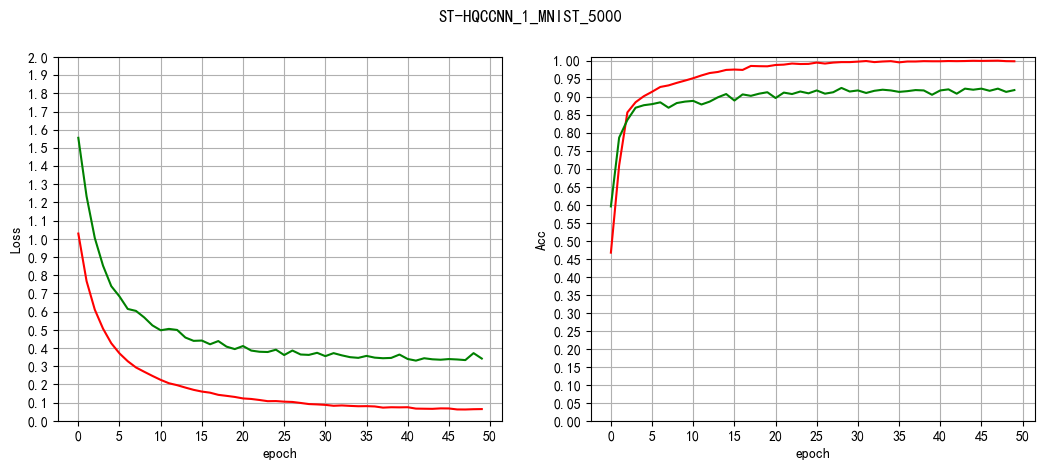

In [15]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

x = np.arange(0, 50)

width, height = 32, 12 
fig = plt.figure()
fig.suptitle("ST-HQCCNN_1_MNIST_5000", fontsize=12)

fig.set_size_inches(width / 2.54, height / 2.54)

plt.subplot(1, 2, 1)  # fig.1是一个一行两列布局的图，且现在画的是左图
loss_1 = train_all_loss
loss_2 = val_all_loss
line1, = plt.plot(x, loss_1, color='r')
line2, = plt.plot(x, loss_2, color='g')
# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Loss")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0, 2.0001, 0.1))
plt.ylim(0, 2)


plt.subplot(1, 2, 2)  # 当前图变为fig.1的右图
acc_1 = train_all_acc
acc_2 = val_all_acc

line1, = plt.plot(x, acc_1, color='r')
line2, = plt.plot(x, acc_2, color='g')

# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Acc")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0.00, 1.01, 0.05))
plt.ylim(0.00, 1.01)

plt.show()


In [16]:
model_Q = DressedQuantumNet_S()
model_Q = torch.load('Result/ST-HQCCNN_1_MNIST_5000.pth', map_location=device)
model_Q.eval()

DressedQuantumNet_S(
  (flat_net): Flatten(start_dim=1, end_dim=-1)
  (pre_net): Linear(in_features=784, out_features=256, bias=True)
  (post_net): Linear(in_features=4, out_features=10, bias=True)
)

In [17]:
print('ST-HQCCNN_1_MNIST_5000')

totel_acc=0.0

for j, (inputs, labels) in enumerate(test_dataloader):
    outputs = model_Q(inputs)
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    totel_acc += acc.item() * inputs.size(0)
print('测试集1000：')
print(totel_acc/test_data_size)

ST-HQCCNN_1_MNIST_5000
测试集1000：
0.924
